# Geometric Brownian Motion - BSQF Assessment

This project is a sample, done by Bocconi Students Quantitative Finance, for the Fall 2025 Recruitment Process.
In this project we are going to:
- Gather real stock market prices
- Calculate their drift and volatility for estimating their future path esing GBM 
- Use Euler-Maruyama to conduct multiple simulations
- Compare the results with reality
- Introduce a theoretical discussion about GBM limits

## Part 1: Market data gathering

In [1]:
# Let's start by importing useful libraries
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Now download the data that we want to analyze and check them
data = yf.download("SPY", "2019-01-01", "2025-09-30", interval="1d", auto_adjust=False)
data.head

[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of Price        Adj Close       Close        High         Low        Open  \
Ticker             SPY         SPY         SPY         SPY         SPY   
Date                                                                     
2019-01-02  225.660187  250.179993  251.210007  245.949997  245.979996   
2019-01-03  220.275314  244.210007  248.570007  243.669998  248.229996   
2019-01-04  227.653595  252.389999  253.110001  247.169998  247.589996   
2019-01-07  229.448608  254.380005  255.949997  251.690002  252.690002   
2019-01-08  231.604279  256.769989  257.309998  254.000000  256.820007   
...                ...         ...         ...         ...         ...   
2025-09-23  663.210022  663.210022  667.340027  661.979980  666.719971   
2025-09-24  661.099976  661.099976  664.609985  659.669983  664.510010   
2025-09-25  658.049988  658.049988  659.409973  654.409973  657.940002   
2025-09-26  661.820007  661.820007  662.369995  657.880005  659.510010   
2025-09-

### Choice of the value 🤔

As we can see, we have numerous data, not a single price stream. Unfortunately while covering this model we are not going to discuss this bias, so let's make some considerations.
We have to chose 1 value to analyze, considering that we want to predict price direction we can instantly rule out "Volume" and, going further, we can also leave "High" and "Low" out, since they represent the day's spikes.

We are left with 3 interesting values "Open", "Close" and "Close Adj". As the trading day ends most of the prices tends to be more truthfully representative of the real value of the stock. In fact open prices are influenced by overnight rumors and informations and can be mostly affected by either hype or panic. In addition closing price can be seen as settlement prices that is the value that the traders agreed the security to be worth after an entire day of trading. 

Finally choosing between "Close" and "Close Adj" we prefer the Adjusted version because in the stock market management decisions can artificially twist stock prices, for example dividends or stock plits can lower the price of a stock. It follows that this "artificial jumps" in stock prices are not beneficial for this model, thus we want to use a data source that ignores price changes generated by these events.

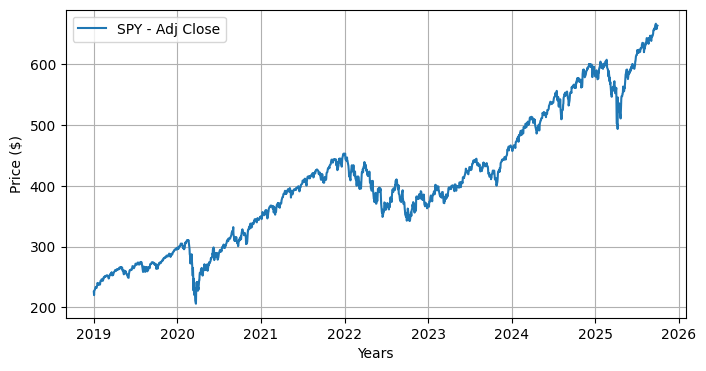

Ticker             SPY
Date                  
2019-01-02  225.660187
2019-01-03  220.275314
2019-01-04  227.653595
2019-01-07  229.448608
2019-01-08  231.604279
2019-01-09  232.686691
2019-01-10  233.507492
2019-01-11  233.597687
2019-01-14  232.172577
2019-01-15  234.833405 

 Ticker             SPY
Date                  
2025-09-16  658.175232
2025-09-17  657.357544
2025-09-18  660.429016
2025-09-19  663.700012
2025-09-22  666.840027
2025-09-23  663.210022
2025-09-24  661.099976
2025-09-25  658.049988
2025-09-26  661.820007
2025-09-29  663.679993


In [3]:
# We extract the chosen data...
adj_close = data["Adj Close"]

# ... and plot it
plt.figure(figsize=(8,4))
plt.plot(adj_close, label="SPY - Adj Close")
plt.xlabel("Years")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

# We print the head and the tail to get some infos about the data
print(adj_close.head(10),"\n"*2, adj_close.tail(10))

## Part 2: Parameters estimation

In [4]:
# Now let's calculate the log-returns 
log_rets = np.log(adj_close / adj_close.shift(1))

# Now we have to discard the first value of the serie, that is a NaN, cause it has no numerator
log_rets=log_rets.dropna()
print(log_rets.head())

Ticker           SPY
Date                
2019-01-03 -0.024152
2019-01-04  0.032947
2019-01-07  0.007854
2019-01-08  0.009351
2019-01-09  0.004663


Key Take-away: We use logarithmic returns instead of atithmetic returns, cause it's assumed they are more consistent with the model assumpion that the returns are normally distributed

In [5]:
# At this point we need to estimate the volatility and the drift of the model 
mu = log_rets.mean()
sigma = log_rets.std()
print(mu, sigma)

Ticker
SPY    0.000637
dtype: float64 Ticker
SPY    0.012634
dtype: float64


## ⚠️Alert!⚠️
Please note that for the sake of the simplicity we calculated the drift with a simple arithmetic mean and assumed volatility to be constant, but this assumptions are very strong. Too strong for reality, but let's consider a ideal enviroment (detached from reality).

What we need to consider anyway is that the return and the volatily we calculated are on a day-basis, but for our model we need annualized parameters.
The SDE for GBM is:
$$
dS_t = \mu S_t\,dt + \sigma S_t\,dW_t
$$


In [6]:
mu_annual = mu * 252
sigma_annual = sigma * np.sqrt(252)

print("Annualized Drift (μ):", float(mu_annual), "Annualized volatility (σ):", float(sigma_annual), "\n")

Annualized Drift (μ): 0.1604781558156243 Annualized volatility (σ): 0.20056149911684704 



C:\Users\alema\AppData\Local\Temp\ipykernel_8480\2401329671.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Annualized Drift (μ):", float(mu_annual), "Annualized volatility (σ):", float(sigma_annual), "\n")


These results may seem exagerated, but you havo to consider that during the past 5 years S&P500 doubled its value, making the 0.16 logarithmic return (about 17% in arithmetic terms) pretty understandable

## Part 3: Run simulations with Euler-Maruyama

Now we're gonna firstly find the analytical solution to this equation and only after simulate some paths

So let's consider the Stochastic differential equation for the Geometric Brownian Motion:
$$
dS_t = \mu S_t\,dt + \sigma S_t\,dW_t
$$
We need to state:
$$
X_t = ln(S_t)
$$
For Ito's lemma:
$$
dX_t = dS_t/S_t - (dS_t)^2/2S_t
$$
From the latter eqution follows the analytical solution:
$$
S_t = S_0exp[(\mu - \sigma^2/2)t+\sigma W_t]
$$
For Euler-Maruyama we have: 
$$ \Delta W_t \sim N(0, \Delta t) $$
Thus:
$$
S_{t+\Delta t} = S_texp[(\mu - \sigma^2/2)\Delta t+\sigma \sqrt{\Delta t} Z ]
$$
where $$Z \sim N(0,1)$$


### Now we are ready for starting our simulation 🏁

In [7]:
# Let's initiate out parameters, we let S0 be a randomic price between 1st Jan 2019 and 30 Sept 2024
np.random.seed(8) 
starting_day = np.random.randint(1, 1449)
S0 = adj_close.iloc[starting_day]   
T = 1                     
dt = 1/252                
N = int(T / dt)           
M = 1000

# Let's create one thousand 252-rows arrays, represanting the shocks (Z value) for every day in the 1000 paths
np.random.seed(8) 
Z = np.random.randn(N, M)  

# Create the price matrix (empty except row 1) that we will fill
S = np.zeros((N, M))
S[0, :] = S0

# Now let's implement the Euler-Maruyama formula for simulating 1000 paths
for t in range(1, N):
    for m in range(M):
        S[t, m] = S[t-1, m] * np.exp((mu_annual - 0.5 * sigma_annual**2) * dt + sigma_annual * np.sqrt(dt) * Z[t, m])

C:\Users\alema\AppData\Local\Temp\ipykernel_8480\3556263323.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S[t, m] = S[t-1, m] * np.exp((mu_annual - 0.5 * sigma_annual**2) * dt + sigma_annual * np.sqrt(dt) * Z[t, m])


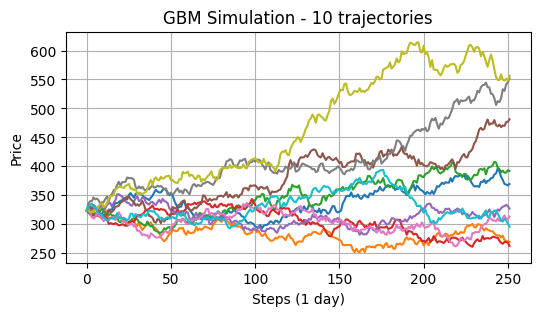

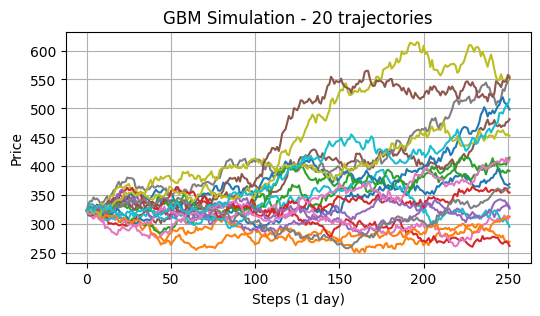

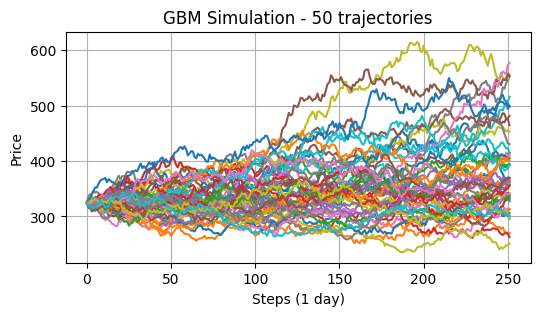

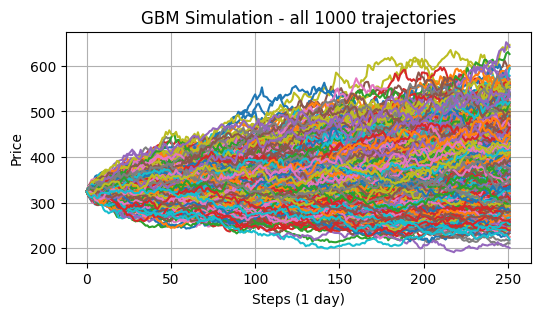

In [8]:
#Now let's plot some data

# We try with only 10 paths to make it readable 
plt.figure(figsize=(6,3))
plt.plot(S[:, :10]) 
plt.title("GBM Simulation - 10 trajectories")
plt.xlabel("Steps (1 day)")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# Let's try 20 too
plt.figure(figsize=(6,3))
plt.plot(S[:, :20]) 
plt.title("GBM Simulation - 20 trajectories")
plt.xlabel("Steps (1 day)")
plt.ylabel("Price")
plt.grid(True)
plt.show()

#50
plt.figure(figsize=(6,3))
plt.plot(S[:, :50]) 
plt.title("GBM Simulation - 50 trajectories")
plt.xlabel("Steps (1 day)")
plt.ylabel("Price")
plt.grid(True)
plt.show()

#all (that's actually a no-brainer, but done for the sake of curiosity)
plt.figure(figsize=(6,3))
plt.plot(S[:, :1000]) 
plt.title("GBM Simulation - all 1000 trajectories")
plt.xlabel("Steps (1 day)")
plt.ylabel("Price")
plt.grid(True)
plt.show()

## Part 4: Model vs Reality
Now that we have simulated all the 1000 paths we can procede to compare the model with the real data.
We will look at the return distribution and the overall trajectory. 
In this part we will mainly focus on data visualization and metrics, while in Part 5 we will draw the final conclusions

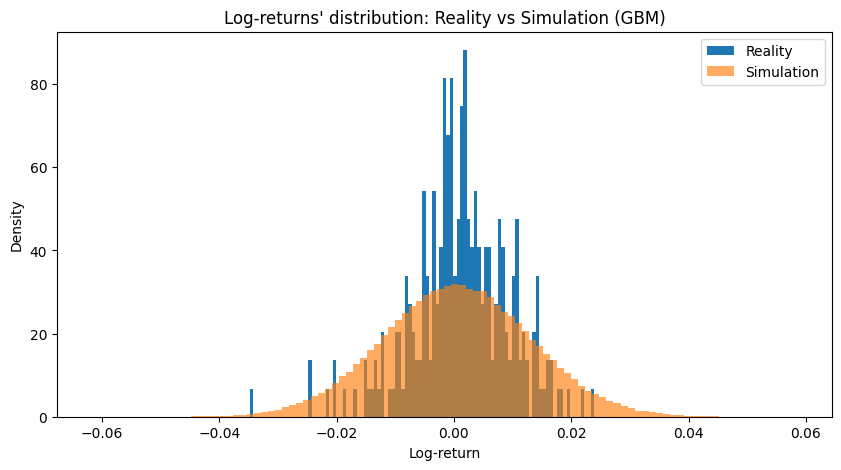

Reality:
Mean =  0.0010512164501835122 
Real variance = 0.008475265560438037 
Skew =  -0.5022646866225557 
Kurtosis =  4.410669422323254


Simulation:
Mean =  0.0005401089352775868 
Real variance = 0.01262319063199295 
Skew =  0.005526851608535067 
Kurtosis =  3.011121892021237


In [9]:
# Here we gather the real prices for the same interval used for the simulation and their returns
real_prices = adj_close.iloc[starting_day : starting_day+N].values
log_returns_real = np.log(real_prices[1:] / real_prices[:-1])

# While here we calculate the log-returns for the GBM
log_returns_sim = np.log(S[1:,:] / S[:-1,:])  

# Now plot the histogram, to show how the results are distributed (we used alpha = 0.5 to make simulated returns transparent)
plt.figure(figsize=(10,5))
plt.hist(log_returns_real, bins=100, density=True, label="Reality")
plt.hist(log_returns_sim.flatten(), bins=100, density=True, alpha=0.65, label="Simulation")
plt.legend()
plt.title("Log-returns' distribution: Reality vs Simulation (GBM)")
plt.xlabel("Log-return")
plt.ylabel("Density")
plt.show()

# Now let's consider the time series for the real results
log_returns_real_series = pd.Series(log_returns_real.flatten())
log_returns_sim_series = pd.Series(log_returns_sim.flatten())

# Print some metrics
print("Reality:\nMean = ", log_returns_real.mean(), "\nReal variance =", log_returns_real.std(), "\nSkew = ", log_returns_real_series.skew(), "\nKurtosis = ", log_returns_real_series.kurtosis()+3)
print("\n")
print("Simulation:\nMean = ", log_returns_sim.mean(), "\nReal variance =", log_returns_sim.std(), "\nSkew = ", log_returns_sim_series.skew(), "\nKurtosis = ", log_returns_sim_series.kurtosis()+3)

### The four moments of the distributions 4️⃣
#### 1) Mean
The mean in reality is higher that the simulated mean, mostly because the return for the year randomly selected was higher than mean return for the overall period and that led to an underperformance of the GBM that, with high number of simulations, will always return the drift value as the mean increase

#### 2) Volatility
It's not surprising that the simulations returns are normally distributed around the drift, but due to this our simulation is pretty much more volatile than the reality where the result are concentrated in certain frequencies

#### 3) Skewness
The distribution skewness is negative in reality, while pretty neutral in the simulation (due to the "forced" normal distribution). This reflects the expression “Bulls climb the stairs, bears jump out the window”, as there are some negative outliers, generated in the first months, that drags down the skewness

#### 4) Kurtosis
The same outliers that drags down skewness push up the kurtosis in the reality graph, as they weight down the tails.

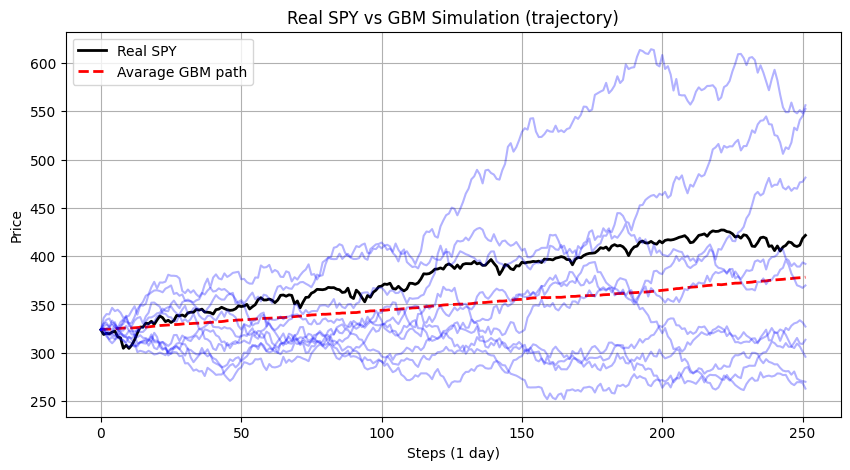

Tracking Error: 0.008495876121577272


In [10]:
# Simulation's mean path and returns
mean_path = S.mean(axis=1)
log_returns_sim_mean = np.log(mean_path[1:] / mean_path[:-1])

# Plot simulations' path and reality in the same graph
plt.figure(figsize=(10,5))
plt.plot(real_prices, label="Real SPY", color="black", linewidth=2)
plt.plot(mean_path, label="Avarage GBM path", color="red", linestyle="--", linewidth=2)
plt.plot(S[:, :10], alpha=0.3, color="blue")  # We use 10 trajectories to make it readable
plt.legend()
plt.title("Real SPY vs GBM Simulation (trajectory)")
plt.xlabel("Steps (1 day)")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# Tracking Error
tracking_error = np.sqrt(np.mean((log_returns_sim_mean - log_returns_real)**2))
print("Tracking Error:", tracking_error)


### Traking Error and Trajectory
As previously said the GBM underestimate the real performance because of the refence period chosen, but as the tracking error is pretty low (<1%), we can state that the model is pretty close to reality. Anyway that's not a jaw-dropping result, as both volatility and mean return were known in advance.

## Part 5: Final Theoretical Conclusion 📜

##### Data analysis:
As we've seen from the data, our simulation suffers from various problems: first of all, the skew of the distribution is not close to reality, as the simulation distribution is too unrealistic. Another problem is the absence of thick tail in the simulation that, as we've seen, are present in reality, thus when using this model we will struggle to predict daily drawdowns or possible falsh-crashes.  


##### Reality adherence:
Even if the model wasn't really able to predict reality faithfully the tracking error was pretty low and the trend highlighted by the mean simulated path was pretty accurate. Unfortunately, we have to consider how we "cheated", in fact while carrying out the project volatility and, especially, mean return were known, consequently the drift on a one-year span would have surely resulted in a good trend predictor.  
What we can really confort ourselves about is that, even when forcasting, if we succed in finding the right mean and volatility (not the easiest of the tasks), we can almost faithfully simulate stock performance.

##### General problems:
Now if we look at the main problems of the GBM, at the end of this simulation, we can highlight:  
- Constant volatility: throughtout the entire project volatility was assumed constant, but as we know in reality, we can't deny that it varies with time
- Normal distribution of log-returns: as the metrics of Plot 1 showed us, the Skewness and Kurtosis of the real distribution tend to be less regular compared to the simulation
- Absence of jumps: even if we haven't talked about that bias, our model doesn't consider price jumps, but assume the price variable to be continuos
- No correlation: another not-talked yet argument is this. Please note that in reality returns can be often auto-correlated while here we have a guassian distribution, thus the returns are i.i.d. (indipendently identical distributed) instead.

##### Future progress:
This biases could be, in part, fixed by introducing models for variable volatility estimation (GARCH models) or jumps-considering model, like Jump-Diffusion model.  
Another intresting follow-up could be seeing as this model contribute to the Black-Scholes option pricing model and the further models, like Black-Scholes-Merton (introducing stochastic interest rate and dividends' effect) model and Heston model (interesting as it consider stochastic volatility)

<p style="text-align:right; margin-right: 5%;"><em>written by Alessandro Marazzi, Co-head of BSQF's Quant Research division</em></p>
